Plot tas behavior versus melt occurrence
===

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

from netCDF4 import Dataset
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.text import Text

%load_ext autoreload
%autoreload 2
from model import Model
# from GCNet import GCNet
from plotUtils import PlotUtils
from itertools import izip
import matplotlib as mpl

pd.options.mode.chained_assignment = None

Global data
----

In [3]:
# onethird = 1./3.*100
# percs = [ 1, 5, 10, onethird, onethird*2, 90, 95, 99 ]
# percs = [ 1, 5, 10, 90, 95, 99 ]

yr1a = "1986"
yr2a = "2015"
yrsHist = yr1a+"-"+yr2a

# yr1a = "1996"
# yr2a = "2005"
# yrsHist = yr1a+"-"+yr2a

# yr1b = "2071"
# yr2b = "2080"
# yrsFuture = yr1b+"-"+yr2b

# colors = ["bright blue", "grass green", "red", "tangerine"]
# sns.set(palette = sns.xkcd_palette(colors) )

# sns.set( context = "talk" )
# sns.set( style = "whitegrid" )

Mlsm = Model("wrf_geog.nc", "landmask.nc")
lsm2d = Mlsm.loadData( "LANDMASK", True )
lsm = lsm2d.values.reshape(-1,).tolist()

Morog = Model("wrf_geog.nc", "lat_lon_orog.nc")
orog2d = Morog.loadData( "orog", True )
orog = orog2d.values.reshape(-1,).tolist()

Utility function to mask a variable
---

In [4]:
def compress(data, selectors):
    # compress('ABCDEF', [1,0,1,0,1,1]) --> A C E F
    return (d for d, s in izip(data, selectors) if s)

Load and prepare a data file
---

In [176]:
def loadData( var, model, period, mms, suff, mask = None ):
    # Load data, convert to 1-d
    
    if model == "melt":
        modelDir = "/Users/dbr/Documents/gismelt/mote_sfc_melt"
        yrs = yrsHist
        modelFN = "Mote_1986-2015_"+mms+"_fraction.nc"
    if model == "erai":
        modelDir = "/Users/dbr/Documents/gismelt/models_vs_obs/gis_erai"
        yrs = yrsHist
        modelFN = "tas_wrf_erai_"+yrs+"_"+mms+"_d_thresh.nc"
    if model == "cesmle":
        if period == "hist":
            modelDir = "/Users/dbr/Documents/gismelt/models_vs_obs/gis_cesmle"
            yrs = yrsHist
        else:
            modelDir = "/Users/dbr/Documents/gismelt/models_vs_obs/gis_cesmle"
            yrs = yrsFuture
        if suff is None:
            modelFN = "tas_wrf_cesmle_ens_"+yrs+"_"+mms+"_d_thresh.nc"
        else:
            modelFN = "tas_wrf_cesmle_ens_"+yrs+"_"+mms+"_d_"+suff+"_thresh.nc"
    if model == "cesmlw":
        modelDir = "/Users/dbr/Documents/gismelt/models_vs_obs/gis_cesmlw"
        yrs = yrsFuture
        if suff is None:
            modelFN = "tas_wrf_cesmlw_ens_"+yrs+"_"+mms+"_d_thresh.nc"
        else:
            modelFN = "tas_wrf_cesmlw_ens_"+yrs+"_"+mms+"_d_"+suff+"_thresh.nc"
        
    M = Model("wrf_geog.nc", modelDir+"/"+modelFN)

    X = M.loadData( var, True )
    X1d = X.values.reshape(-1,).tolist()
    print "X1d: "+str(len(X1d))+" points, min = "+str(min(X1d))
    
    if mask is None:
        X1dMask = X1d
    else:
        maskVar = mask[0]
        if maskVar == "lsm":  # masking against landsea mask
            X1dMask = list( compress( X1d, lsm ) )
        else:
            if maskVar == "orog":  # masking against orography
                X1dLSM = np.array( list( compress( X1d, lsm )))
                orogLSM = np.array( list( compress( orog, lsm )))
                maskElev = mask[1]
                if maskElev > 0:
                    msk = np.where( orogLSM > abs(maskElev) )[0]
                    X1dMask = X1dLSM[ msk ].tolist()
#                     X1dMask = X1dLSM[ np.where( orogLSM > maskElev ) ].tolist()
                else:
                    msk = np.where( orogLSM < abs(maskElev) )[0]
                    X1dMask = X1dLSM[ msk ].tolist()
#                     X1dMask = X1dLSM[ np.where( orogLSM < abs(maskElev) ) ].tolist()
            else:
                print "Mask variable not recognized"
                return None
    
    return X1dMask

Scatter plot
---

In [128]:
def scatterPlot( X, Y ):
    plt.plot( X, Y, 'or' )

Hex bin plot
---

In [129]:
def hexBinPlot( X, Y, nbin, cmap ):
    plt.hexbin( X, Y, gridsize = nbin, cmap = cmap, norm = mpl.colors.LogNorm() )
    cb = plt.colorbar(label='count in bin')

2d histogram plot
---

In [9]:
def hist2dPlot( X, Y, nbin, cmap ):
    plt.hist2d( X, Y, bins = nbin, cmap = cmap, norm = mpl.colors.LogNorm() )
    cb = plt.colorbar(label='count in bin')

Drop NaN elements
---

In [193]:
def dropNaN( X, Y, theNaN ):
#     nanix = np.where(np.isnan(np.array(Y)))
    nanix = np.where(np.array(Y) == theNaN )[0]
    print nanix
    nanlist = np.ones(len(Y))
    nanlist[nanix] = 0
    nanlist = nanlist.tolist()
    X2 = list( compress( X, nanlist ))
    Y2 = list( compress( Y, nanlist ))
#     return nanix
    return ( X2, Y2 )

Run the Plots
===

Prepare data
---

In [191]:
mdl1 = "erai"
# v1 = "fraction"
v1 = "degDayAcc"

mdl2 = "melt"
v2 = "fraction"

mms = "JJA"
suff = None
cmap = "Blues"
nbin = 20
mask = None
# mask = ( "orog", -1500 )
# mask = ( "lsm", )

X6 = loadData( v1, mdl1, None, "06", suff, mask )
Y6 = loadData( v2, mdl2, None, "06", suff, mask )
X7 = loadData( v1, mdl1, None, "07", suff, mask )
Y7 = loadData( v2, mdl2, None, "07", suff, mask )
X8 = loadData( v1, mdl1, None, "08", suff, mask )
Y8 = loadData( v2, mdl2, None, "08", suff, mask )

X = X6+X7+X8
Y = Y6+Y7+Y8
X2, Y2 = dropNaN( X, Y, min(Y))
# nanix = dropNaN( X, Y, min(Y))
print "X: "+str(len(X2))+" points"
print "X2: "+str(len(X2))+" points"

X1d: 43143 points, min = 0.0
X1d: 43143 points, min = -999.0
X1d: 43143 points, min = 0.0
X1d: 43143 points, min = -999.0
X1d: 43143 points, min = 0.0
X1d: 43143 points, min = -999.0
(array([     0,      1,      2, ..., 129426, 129427, 129428]),)
X: 23418 points
X2: 23418 points


Scatter plot
---

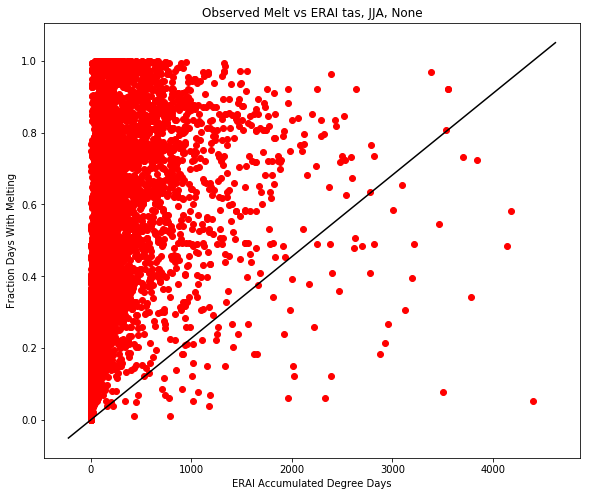

In [187]:
fig, ax = plt.subplots( figsize=(9.6,8) )

scatterPlot( X2, Y2 )
plt.title( "Observed Melt vs "+mdl1.upper()+" tas, "+mms+", "+str(mask) )
# plt.xlabel( mdl1.upper()+" Fraction Days Above Freezing" )
plt.xlabel( mdl1.upper()+" Accumulated Degree Days" )
plt.ylabel( "Fraction Days With Melting" )
xmin, xmax = ax.get_xlim();
ymin, ymax = ax.get_ylim();
plt.plot( (xmin,xmax), (ymin,ymax), '-k' );
# ax.set_aspect('equal', 'box')

hist2d plot
---

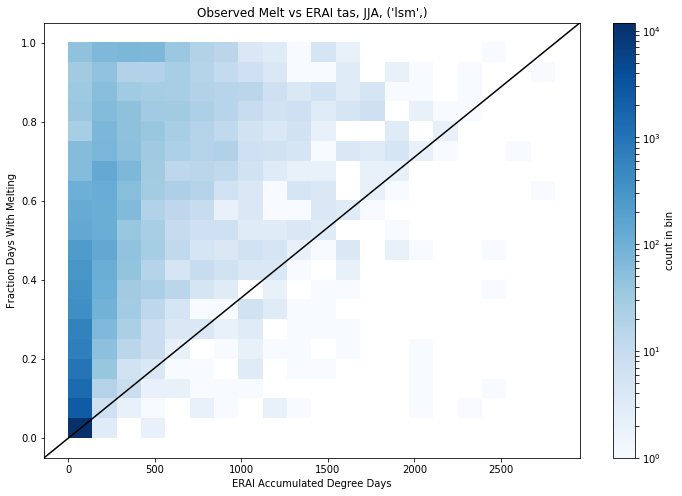

In [168]:
fig, ax = plt.subplots( figsize=(12,8) )

hist2dPlot( X2, Y2, nbin, cmap )

plt.title( "Observed Melt vs "+mdl1.upper()+" tas, "+mms+", "+str(mask) )
# plt.xlabel( mdl1.upper()+" Fraction Days Above Freezing" )
plt.xlabel( mdl1.upper()+" Accumulated Degree Days" )
plt.ylabel( "Fraction Days With Melting" )

ax.set_xlim( xmin, xmax );
ax.set_ylim( ymin, ymax );
plt.plot( (xmin,xmax), (ymin,ymax), '-k' );
# ax.set_aspect('equal', 'box')

hexbin plot
---

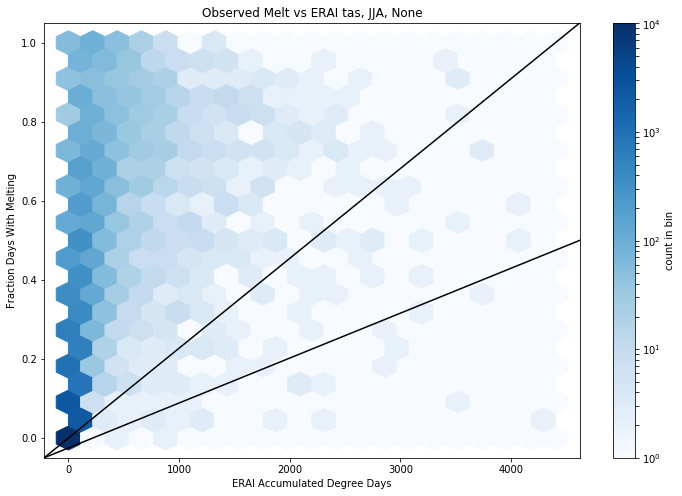

In [182]:
fig, ax = plt.subplots( figsize=(12,8) )

hexBinPlot( X2, Y2, nbin, cmap )

plt.title( "Observed Melt vs "+mdl1.upper()+" tas, "+mms+", "+str(mask) )
# plt.xlabel( mdl1.upper()+" Fraction Days Above Freezing" )
plt.xlabel( mdl1.upper()+" Accumulated Degree Days" )
plt.ylabel( "Fraction Days With Melting" )

ax.set_xlim( xmin, xmax );
ax.set_ylim( ymin, ymax );
plt.plot( (xmin,xmax), (ymin,ymax), '-k' );
plt.plot( (xmin,xmax), (ymin,0.5), '-k' );
# ax.set_aspect('equal', 'box')

Scatter & Hexbin plots
---

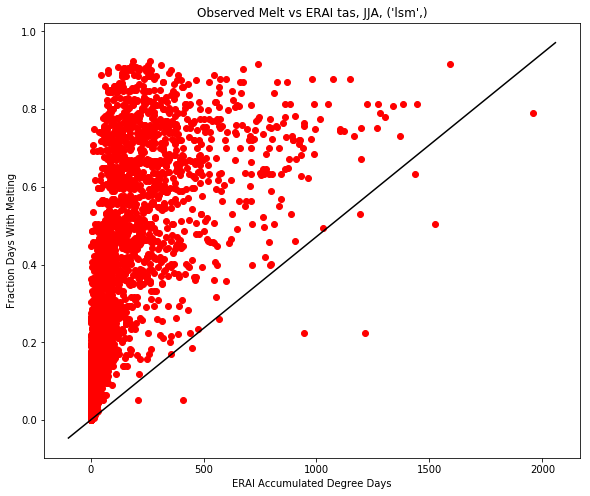

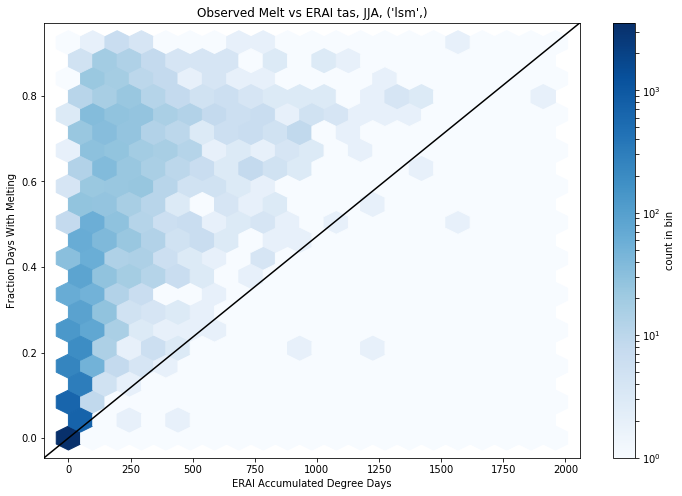

In [140]:
fig, ax = plt.subplots( figsize=(9.6,8) )

scatterPlot( X2, Y2 )
plt.title( "Observed Melt vs "+mdl1.upper()+" tas, "+mms+", "+str(mask) )
# plt.xlabel( mdl1.upper()+" Fraction Days Above Freezing" )
plt.xlabel( mdl1.upper()+" Accumulated Degree Days" )
plt.ylabel( "Fraction Days With Melting" )
xmin, xmax = ax.get_xlim();
ymin, ymax = ax.get_ylim();
plt.plot( (xmin,xmax), (ymin,ymax), '-k' );
# ax.set_aspect('equal', 'box')

fig, ax = plt.subplots( figsize=(12,8) )
hexBinPlot( X2, Y2, nbin, cmap )
plt.title( "Observed Melt vs "+mdl1.upper()+" tas, "+mms+", "+str(mask) )
# plt.xlabel( mdl1.upper()+" Fraction Days Above Freezing" )
plt.xlabel( mdl1.upper()+" Accumulated Degree Days" )
plt.ylabel( "Fraction Days With Melting" )
ax.set_xlim( xmin, xmax );
ax.set_ylim( ymin, ymax );
plt.plot( (xmin,xmax), (ymin,ymax), '-k' );
# ax.set_aspect('equal', 'box')

Try to compare to orography
---

In [144]:
# mdl1 = "orog"
# mdl2 = "melt"
# mms = "JJA"
# suff = None
# cmap = "Blues"
# nbin = 15
# mask = None
# ### these two options don't seem to work
# # mask = ( "orog", -2500 )
# # mask = ("lsm",)

# Xo = orog
# Y6 = loadData( mdl2, None, "06", suff, mask )
# Y7 = loadData( mdl2, None, "07", suff, mask )
# Y8 = loadData( mdl2, None, "08", suff, mask )

# X = Xo+Xo+Xo
# Y = Y6+Y7+Y8
# X2, Y2 = dropNaN( Xo, Y6)

hexbin plot
---

In [145]:
# fig, ax = plt.subplots( figsize=(12,8) )

# hexBinPlot( X2, Y2, nbin, cmap )

# plt.title( "Observed Melt vs Orography, "+mms+", "+str(mask) )
# plt.xlabel( "Elevation (m)" )
# plt.ylabel( "Fraction Days With Melting" )
# # ax.set_aspect('equal', 'box')

Code from loadData that tries to do elev1 < X < elev2
===

In [146]:
## can't figure out how to intersect the two lists...
#                     if len( maskElev ) == 1:
#                         if maskElev > 0:
#                             X1dMask = X1dNP[ np.where( orogNP > maskElev ) ].tolist()
#                     else:
#                         print "Mask elevation needs to be a single element"
#                         return None
#                    
#                         if not maskElev[0] is None:
#                             if not maskElev[1] is None:
#                                 X1dMask1 = set( X1dNP[ np.where( orogNP > maskElev[0] )].tolist() )
#                                 X1dMask2 = X1dNP[ np.where( orogNP < maskElev[1] )].tolist()
#                                 X1dMask = [ v for v in X1dMask2 if v in X1dMask1 ]
#                             else:
#                                 X1dMask = X1dNP[ np.where( orogNP > maskElev[0] ) ].tolist()
#                         else:
#                             X1dMask = X1dNP[ np.where( orogNP < maskElev[1] ) ].tolist()